In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jul 31 13:11:33 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install transformers

In [5]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
import torch.nn.functional as F
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import sklearn.utils
import time
import re


In [6]:
# Retrive the data from stored dataset
dataDir = "/content/drive/MyDrive/WoS/data/X11967"
tsvData = os.path.join(dataDir,"WoSDataset_11967.tsv")

tsvData = np.loadtxt(tsvData, dtype=str, delimiter="\t")
print(np.shape(tsvData))

(11967, 4)


In [7]:
print(tsvData[0:10])

[['2' 'Psychology'
  ' interview anxiety interview performance person perception job interview        '
  'the aim of this study was to investigate a the behavioral cues that are displayed by and trait judgments formed about anxious interviewees and b why anxious interviewees receive lower interview performance ratings the behavioral expression of interview anxiety model was created as a conceptual framework to explore these relations we videotaped and transcribed mock job interviews obtained ratings of interview anxiety and interview performance and trained raters to assess several verbal and nonverbal cues and trait judgments the results indicated that few behavioral cues but several traits were related to interviewee and interviewer ratings of interview anxiety two factors emerged from our factor analysis on the trait judgmentsassertiveness and interpersonal warmth mediation analyses were performed and indicated that assertiveness and interpersonal warmth mediated the relation betwe

In [8]:
allLabels = tsvData[:,0]
domains = tsvData[:,1]
keywords = tsvData[:,2]
abstracts = tsvData[:,3]

In [9]:
labels = np.unique(domains, return_counts=True)[0]
labelCounts=  np.unique(domains, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [1499 2107 1132 1925 1617 1959 1728]


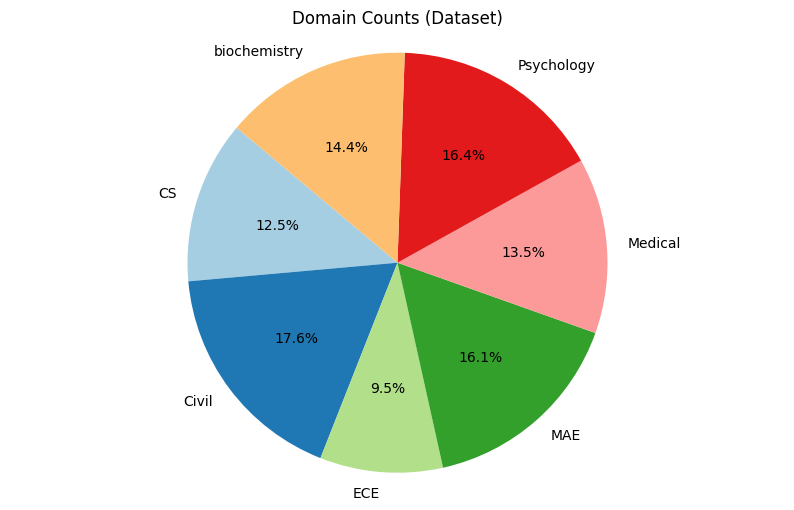

The domain CS has 1499 records in the dataset.
The domain Civil has 2107 records in the dataset.
The domain ECE has 1132 records in the dataset.
The domain MAE has 1925 records in the dataset.
The domain Medical has 1617 records in the dataset.
The domain Psychology has 1959 records in the dataset.
The domain biochemistry has 1728 records in the dataset.


In [10]:
# Visualize domain counts in dataset
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Dataset)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the dataset.")

In [11]:
# Shuffle data
dataShuffled = sklearn.utils.shuffle(tsvData)

abstractsShuffled = dataShuffled[:,3]
keywordsShuffled = dataShuffled[:,2]
domainsShuffled = dataShuffled[:,1]
allLabelsShuffled = dataShuffled[:,0]

print("Number of abstracts: ", len(abstractsShuffled))
print("Shape of abstracts: ", np.shape(abstractsShuffled))
print(abstractsShuffled[0:2])

print("Number of keywords: ", len(keywordsShuffled))
print("Shape of keywords: ", np.shape(keywordsShuffled))
print(abstractsShuffled[0:2])

print("Number of domains: ", len(domainsShuffled))
print("Shape of domains: ", np.shape(domainsShuffled))
print(domainsShuffled[0:2])

print("Number of labels: ", len(allLabelsShuffled))
print("Shape of labels: ", np.shape(allLabelsShuffled))
print(allLabelsShuffled[0:2])


# Convert labels to integer
allLabelsDigitShuffled = allLabelsShuffled.astype(int)

print(abstractsShuffled[0:10])
print(keywordsShuffled[0:10])
print(domainsShuffled[0:10])
print(allLabelsShuffled[0:10])
print(allLabelsDigitShuffled[0:10])

Number of abstracts:  11967
Shape of abstracts:  (11967,)
['under certain conditions traction machines with short axial length and relatively large diameter are required if the space constraints do not allow for a conventional machine design with a low number of poles and a distributed winding a machine with a higher number of poles and a tooth coil winding can be a possible solution as a consequence also the lamination steel the winding copper and the skewing of the machine have to be adapted taking account of the special properties of this type of machine a traction generator with short axial length and high power density was built'
 'we present a frameinvariant method for detecting coherent structures from lagrangian flow trajectories that can he sparse in number as is the case in many fluid mechanics applications of practical interest the method based on principles used in graph colouring and spectral graph drawing algorithms examines a measure of the kinematic dissimilarity of all

In [12]:
# Split dataset into training and testing (80/20 split)
train_data, test_data = train_test_split(dataShuffled, test_size=0.2, random_state=42)
print(np.shape(train_data))
print(np.shape(test_data))

# Further split training data into training and validation (80/20 split of training set)
_, val_data = train_test_split(test_data, test_size=0.2, random_state=42)
print(np.shape(train_data))
print(np.shape(test_data))
print(np.shape(val_data))
# Load SciBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

(9573, 4)
(2394, 4)
(9573, 4)
(2394, 4)
(479, 4)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [13]:
abstractsTrain = train_data[:,3]
keywordsTrain = train_data[:,2]
domainsTrain = train_data[:,1]
allLabelsTrain = train_data[:,0]

print("Number of abstracts: ",len(abstractsTrain))
print("Shape of abstracts: ",np.shape(abstractsTrain))
print("Number of keywords: ",len(keywordsTrain))
print("Shape of keywords: ",np.shape(keywordsTrain))
print("Number of domains: ",len(domainsTrain))
print("Shape of domains: ",np.shape(domainsTrain))
print("Number of labels: ",len(allLabelsTrain))
print("Shape of labels: ",np.shape(allLabelsTrain))

print(abstractsTrain[0:2])
print(keywordsTrain[0:2])
print(domainsTrain[0:2])
print(allLabelsTrain[0:2])

Number of abstracts:  9573
Shape of abstracts:  (9573,)
Number of keywords:  9573
Shape of keywords:  (9573,)
Number of domains:  9573
Shape of domains:  (9573,)
Number of labels:  9573
Shape of labels:  (9573,)
['in recent years research on magnesium mg alloys had increased significantly for hard tissue replacement and stent application due to their outstanding advantages firstly mg alloys have mechanical properties similar to bone which avoid stress shielding secondly they are biocompatible essential to the human metabolism as a factor for many enzymes in addition main degradation product mg is an essential trace element for human enzymes the most important reason is they are perfectly biodegradable in the body fluid however extremely high degradation rate resulting in too rapid loss of mechanical strength in chloride containing environments limits their applications engineered artificial biomaterials with appropriate mechanical properties surface chemistry and surface topography are

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [1204 1691  899 1561 1288 1567 1363]


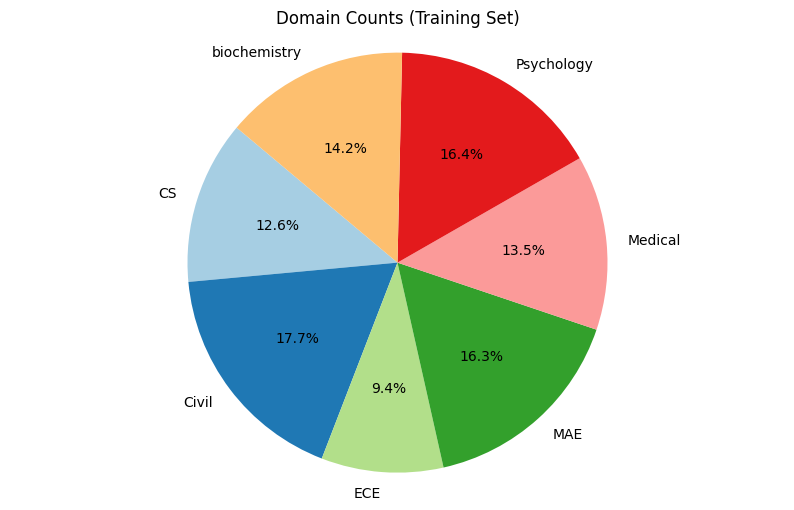

The domain CS has 1204 records in the training set.
The domain Civil has 1691 records in the training set.
The domain ECE has 899 records in the training set.
The domain MAE has 1561 records in the training set.
The domain Medical has 1288 records in the training set.
The domain Psychology has 1567 records in the training set.
The domain biochemistry has 1363 records in the training set.


In [14]:
labels = np.unique(domainsTrain, return_counts=True)[0]
labelCounts =  np.unique(domainsTrain, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

nAbstract = len(abstractsTrain)
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Training Set)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the training set.")

In [15]:
abstractsTest = test_data[:,3]
keywordsTest = test_data[:,2]
domainsTest = test_data[:,1]
allLabelsTest = test_data[:,0]

print("Number of abstracts: ",len(abstractsTest))
print("Shape of abstracts: ",np.shape(abstractsTest))
print("Number of keywords: ",len(keywordsTest))
print("Shape of keywords: ",np.shape(keywordsTest))
print("Number of domains: ",len(domainsTest))
print("Shape of domains: ",np.shape(domainsTest))
print("Number of labels: ",len(allLabelsTest))
print("Shape of labels: ",np.shape(allLabelsTest))

# arr = np.array(domainsTest)
# cleaned_domains = np.char.strip(arr)
# print("Cleaned arr ", cleaned_domains)
# domainsLabelsTest = cleaned_domains
# print("Labels domains ", domainsLabelsTest)

print(abstractsTest[0:2])
print(keywordsTest[0:2])
print(domainsTest[0:2])
print(allLabelsTest[0:2])

Number of abstracts:  2394
Shape of abstracts:  (2394,)
Number of keywords:  2394
Shape of keywords:  (2394,)
Number of domains:  2394
Shape of domains:  (2394,)
Number of labels:  2394
Shape of labels:  (2394,)
['minimum energy control problem for the fractional positive electrical circuits is formulated and solved sufficient conditions for the existence of solution to the problem are established a procedure for solving of the problem is proposed and illustrated by an example of fractional positive electrical circuit'
 'background breast cancer is the most frequently diagnosed cancer in women resident macrophages at distant sites provide a highly responsive and immunologically dynamic innate immune response against foreign infiltrates despite extensive characterization of the role of macrophages and other immune cells in malignant tissues there is very little known about the mechanisms which facilitate metastatic breast cancer spread to distant sites of immunological integrity the mec

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [295 416 233 364 329 392 365]


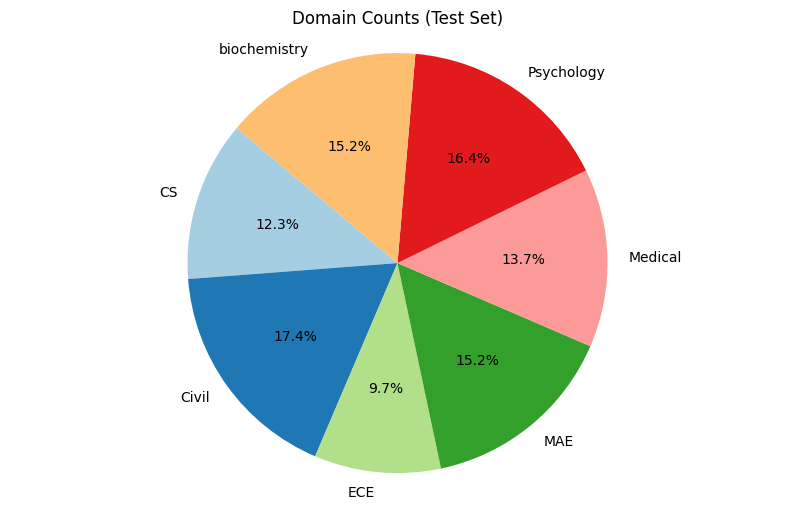

The domain CS has 295 records in the test set.
The domain Civil has 416 records in the test set.
The domain ECE has 233 records in the test set.
The domain MAE has 364 records in the test set.
The domain Medical has 329 records in the test set.
The domain Psychology has 392 records in the test set.
The domain biochemistry has 365 records in the test set.


In [16]:
labels = np.unique(domainsTest, return_counts=True)[0]
labelCounts =  np.unique(domainsTest, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

nAbstract = len(abstractsTest)
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Test Set)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the test set.")

In [17]:
abstractsVal = val_data[:,3]
keywordsVal = val_data[:,2]
domainsVal = val_data[:,1]
allLabelsVal = val_data[:,0]

print("Number of abstracts: ",len(abstractsVal))
print("Shape of abstracts: ",np.shape(abstractsVal))
print("Number of keywords: ",len(keywordsVal))
print("Shape of keywords: ",np.shape(keywordsVal))
print("Number of domains: ",len(domainsVal))
print("Shape of domains: ",np.shape(domainsVal))
print("Number of labels: ",len(allLabelsVal))
print("Shape of labels: ",np.shape(allLabelsVal))

print(abstractsVal[0:2])
print(keywordsVal[0:2])
print(domainsVal[0:2])
print(allLabelsVal[0:2])

Number of abstracts:  479
Shape of abstracts:  (479,)
Number of keywords:  479
Shape of keywords:  (479,)
Number of domains:  479
Shape of domains:  (479,)
Number of labels:  479
Shape of labels:  (479,)
['the migration of ehealth systems to the cloud computing brings huge benefits as same as some security risks searchable encryptionse is a cryptography encryption scheme that can protect the confidentiality of data and utilize the encrypted data at the same time the se scheme proposed by cash et al in crypto2013 and its followup work in ccs2013 are most practical se scheme that support boolean queries at present in their scheme the data user has to generate the search tokens by the counter number one by one and interact with server repeatedly until he meets the correct one or goes through plenty of tokens to illustrate that there is no search result in this paper we make an improvement to their scheme we allow server to send back some information and help the user to generate exact sea

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [55 80 58 63 59 79 85]


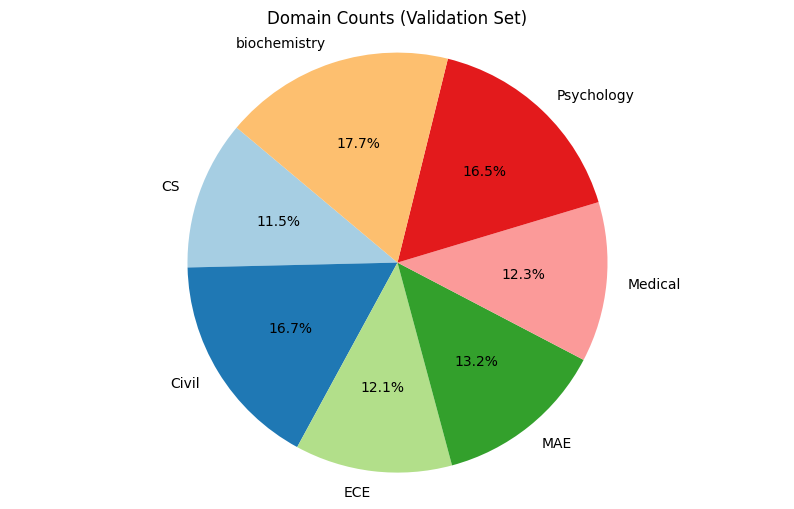

The domain CS has 55 records in the vaidation set.
The domain Civil has 80 records in the vaidation set.
The domain ECE has 58 records in the vaidation set.
The domain MAE has 63 records in the vaidation set.
The domain Medical has 59 records in the vaidation set.
The domain Psychology has 79 records in the vaidation set.
The domain biochemistry has 85 records in the vaidation set.


In [18]:
labels = np.unique(domainsVal, return_counts=True)[0]
labelCounts =  np.unique(domainsVal, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

nAbstract = len(abstractsVal)
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Validation Set)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the vaidation set.")

In [19]:
# Function to tokenize and encode the dataset
def encode_data(data, tokenizer, max_length=128):
    # print(len(data[:,2]))
    inputs = tokenizer(
        data[:,2].tolist(), # keywords
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors="pt"
    )
    # print(len(dataShuffled[:, 0]))
    labels = torch.tensor(data[:, 0].astype(int))
    print("Label length ", len(labels))
    return TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)

In [20]:
print(np.shape(train_data))
print(np.shape(test_data))
print(np.shape(val_data))


(9573, 4)
(2394, 4)
(479, 4)


In [21]:
# Encode training, validation, and testing data
train_dataset = encode_data(train_data, tokenizer)
val_dataset = encode_data(val_data, tokenizer)
test_dataset = encode_data(test_data, tokenizer)



# Data loaders
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=32)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=32)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=32)

Label length  9573
Label length  479
Label length  2394


In [22]:
# Load SciBERT model
print(len(np.unique(train_data[:,0])))
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(np.unique(train_data[:,0])))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

7


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [23]:
model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [24]:
# Optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
total_steps = len(train_dataloader) * 20
num_warmup_steps = 1e-4
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [25]:
def calculate_metrics(valType, predictions, true_labels):
    # Confusion matrix
    if(valType == 'test'):
        cm = confusion_matrix(true_labels, predictions)
        print("Confusion Matrix:\n", cm)

        # Classification report (includes precision, recall, F1 score)
        report = classification_report(true_labels, predictions, target_names=[str(i) for i in range(len(np.unique(true_labels)))])
        print("\nClassification Report:\n", report)

        # Calculate different types of F1 scores, precision, and recall
        f1_macro = f1_score(true_labels, predictions, average='macro')
        f1_micro = f1_score(true_labels, predictions, average='micro')
        f1_weighted = f1_score(true_labels, predictions, average='weighted')

        precision_macro = precision_score(true_labels, predictions, average='macro')
        precision_micro = precision_score(true_labels, predictions, average='micro')
        precision_weighted = precision_score(true_labels, predictions, average='weighted')

        recall_macro = recall_score(true_labels, predictions, average='macro')
        recall_micro = recall_score(true_labels, predictions, average='micro')
        recall_weighted = recall_score(true_labels, predictions, average='weighted')

        print(f"Macro F1 Score: {f1_macro}")
        print(f"Micro F1 Score: {f1_micro}")
        print(f"Weighted F1 Score: {f1_weighted}")

        print(f"Macro Precision: {precision_macro}")
        print(f"Micro Precision: {precision_micro}")
        print(f"Weighted Precision: {precision_weighted}")

        print(f"Macro Recall: {recall_macro}")
        print(f"Micro Recall: {recall_micro}")
        print(f"Weighted Recall: {recall_weighted}")

    elif(valType == 'val'):
        cm = confusion_matrix(true_labels, predictions)
        f1_macro = f1_score(true_labels, predictions, average='macro')
        f1_micro = f1_score(true_labels, predictions, average='micro')
        f1_weighted = f1_score(true_labels, predictions, average='weighted')

        precision_macro = precision_score(true_labels, predictions, average='macro')
        precision_micro = precision_score(true_labels, predictions, average='micro')
        precision_weighted = precision_score(true_labels, predictions, average='weighted')

        recall_macro = recall_score(true_labels, predictions, average='macro')
        recall_micro = recall_score(true_labels, predictions, average='micro')
        recall_weighted = recall_score(true_labels, predictions, average='weighted')
        # print('Val Micro F1:', f1_micro)
        return f1_micro

In [26]:
epochs = 20
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    start_time = time.time()

    # Training
    for step, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, labels = batch


        model.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=input_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    # Validation
    model.eval()
    predictions = []
    true_labels = []

    for batch in val_dataloader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, labels = batch

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=input_mask)
            logits = outputs.logits

        logits = logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()

        batch_predictions = np.argmax(logits, axis=1)
        predictions.extend(batch_predictions)
        true_labels.extend(label_ids)

    val_micro_f1 = calculate_metrics('val', predictions, true_labels)
    elapsed_time = time.time() - start_time

    # Print epoch summary
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"  Train Loss: {avg_train_loss}")
    print(f"  Val Micro F1: {val_micro_f1}")
    print(f"  Time: {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")

Epoch 1/20: 100%|██████████| 300/300 [02:56<00:00,  1.70batch/s]


Epoch 1/20
  Train Loss: 0.8853863862156868
  Val Micro F1: 0.8496868475991649
  Time: 2m 59s


Epoch 2/20: 100%|██████████| 300/300 [02:58<00:00,  1.68batch/s]


Epoch 2/20
  Train Loss: 0.46021602710088094
  Val Micro F1: 0.8810020876826722
  Time: 3m 2s


Epoch 3/20: 100%|██████████| 300/300 [02:58<00:00,  1.68batch/s]


Epoch 3/20
  Train Loss: 0.32703569867958626
  Val Micro F1: 0.860125260960334
  Time: 3m 2s


Epoch 4/20: 100%|██████████| 300/300 [02:58<00:00,  1.68batch/s]


Epoch 4/20
  Train Loss: 0.22105959960569938
  Val Micro F1: 0.8663883089770354
  Time: 3m 2s


Epoch 5/20: 100%|██████████| 300/300 [02:58<00:00,  1.68batch/s]


Epoch 5/20
  Train Loss: 0.1463895049629112
  Val Micro F1: 0.8517745302713988
  Time: 3m 2s


Epoch 6/20: 100%|██████████| 300/300 [02:58<00:00,  1.68batch/s]


Epoch 6/20
  Train Loss: 0.10232898834161461
  Val Micro F1: 0.8538622129436325
  Time: 3m 2s


Epoch 7/20: 100%|██████████| 300/300 [02:58<00:00,  1.68batch/s]


Epoch 7/20
  Train Loss: 0.07013225512734304
  Val Micro F1: 0.8538622129436325
  Time: 3m 2s


Epoch 8/20: 100%|██████████| 300/300 [02:58<00:00,  1.68batch/s]


Epoch 8/20
  Train Loss: 0.05128882211633026
  Val Micro F1: 0.8643006263048016
  Time: 3m 2s


Epoch 9/20: 100%|██████████| 300/300 [02:58<00:00,  1.68batch/s]


Epoch 9/20
  Train Loss: 0.03640274125888633
  Val Micro F1: 0.8643006263048016
  Time: 3m 2s


Epoch 10/20: 100%|██████████| 300/300 [02:58<00:00,  1.68batch/s]


Epoch 10/20
  Train Loss: 0.02330593318756049
  Val Micro F1: 0.860125260960334
  Time: 3m 1s


Epoch 11/20: 100%|██████████| 300/300 [02:58<00:00,  1.68batch/s]


Epoch 11/20
  Train Loss: 0.019236252329622706
  Val Micro F1: 0.8538622129436325
  Time: 3m 2s


Epoch 12/20: 100%|██████████| 300/300 [02:58<00:00,  1.68batch/s]


Epoch 12/20
  Train Loss: 0.01267155800179656
  Val Micro F1: 0.8580375782881002
  Time: 3m 2s


Epoch 13/20: 100%|██████████| 300/300 [02:58<00:00,  1.68batch/s]


Epoch 13/20
  Train Loss: 0.01043963112460915
  Val Micro F1: 0.8580375782881002
  Time: 3m 2s


Epoch 14/20: 100%|██████████| 300/300 [02:58<00:00,  1.68batch/s]


Epoch 14/20
  Train Loss: 0.006277252800064161
  Val Micro F1: 0.8517745302713988
  Time: 3m 2s


Epoch 15/20: 100%|██████████| 300/300 [02:58<00:00,  1.68batch/s]


Epoch 15/20
  Train Loss: 0.005976309186274496
  Val Micro F1: 0.860125260960334
  Time: 3m 2s


Epoch 16/20: 100%|██████████| 300/300 [02:58<00:00,  1.68batch/s]


Epoch 16/20
  Train Loss: 0.004325211733666947
  Val Micro F1: 0.8663883089770354
  Time: 3m 2s


Epoch 17/20: 100%|██████████| 300/300 [02:58<00:00,  1.68batch/s]


Epoch 17/20
  Train Loss: 0.004331387121492298
  Val Micro F1: 0.8580375782881002
  Time: 3m 2s


Epoch 18/20: 100%|██████████| 300/300 [02:58<00:00,  1.68batch/s]


Epoch 18/20
  Train Loss: 0.0023881377434493817
  Val Micro F1: 0.8580375782881002
  Time: 3m 2s


Epoch 19/20: 100%|██████████| 300/300 [02:58<00:00,  1.68batch/s]


Epoch 19/20
  Train Loss: 0.0023582230361838203
  Val Micro F1: 0.8580375782881002
  Time: 3m 2s


Epoch 20/20: 100%|██████████| 300/300 [02:58<00:00,  1.68batch/s]


Epoch 20/20
  Train Loss: 0.0008946173954852081
  Val Micro F1: 0.8517745302713988
  Time: 3m 2s


In [27]:
# Evaluation
model.eval()
predictions = []
true_labels = []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    input_ids, input_mask, labels = batch

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=input_mask)
        logits = outputs.logits

    logits = logits.detach().cpu().numpy()
    label_ids = labels.to('cpu').numpy()

    batch_predictions = np.argmax(logits, axis=1)
    predictions.extend(batch_predictions)
    true_labels.extend(label_ids)

# Calculate and print metrics
calculate_metrics('test', predictions, true_labels)

Confusion Matrix:
 [[257  11   2  13   5   3   4]
 [ 13 178   1  26   7   0   8]
 [  6   3 353   0   6  22   2]
 [ 16  14   6 296  19   4   9]
 [ 14   4   5  14 372   2   5]
 [  5   1  21   2   3 261  36]
 [ 14   4   7   2  10  29 299]]

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.87      0.83       295
           1       0.83      0.76      0.79       233
           2       0.89      0.90      0.90       392
           3       0.84      0.81      0.83       364
           4       0.88      0.89      0.89       416
           5       0.81      0.79      0.80       329
           6       0.82      0.82      0.82       365

    accuracy                           0.84      2394
   macro avg       0.84      0.84      0.84      2394
weighted avg       0.84      0.84      0.84      2394

Macro F1 Score: 0.8369641091571637
Micro F1 Score: 0.8421052631578947
Weighted F1 Score: 0.8418053805388472
Macro Precision: 0.83845230937900

In [28]:
model.save_pretrained('/content/drive/MyDrive/WoS/BERT_WoS_Keywords_11967')

In [29]:
from google.colab import runtime
runtime.unassign()